# Minimum Temperatures

For this analysis and forecasting, we are going to use the Python module [darts](https://unit8co.github.io/darts/), a _do-it-all_ time series library based on the combination of different packages such as `statsmodels` or `fbprophet` and techniques as the Auto-ARIMA or the Exponential Smoothing.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import darts
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox

from timeseries_utils import (
    timeseries_csv_to_df,
    split_train_test,
    plot_results,
    eval_darts_model,
)

Yet again, we start our analysis by loading our data and describing its main characteristics

In [16]:
minimum_temp = timeseries_csv_to_df("../data/daily-minimum-temperatures-in-me.csv")
# Converting the column to numeric value
minimum_temp = minimum_temp[
    pd.to_numeric(minimum_temp["Daily minimum temperatures"], errors='coerce').notnull()
]
minimum_temp["Daily minimum temperatures"] = minimum_temp["Daily minimum temperatures"].astype(np.float32)

## Dataset Description

In [17]:
train_temp, test_temp = split_train_test(minimum_temp)

In [18]:
train_temp.describe()

,Daily minimum temperatures
count,2917.000000
mean,11.116798
std,4.048046
min,0.000000
25%,8.300000
50%,11.000000
75%,13.800000
max,26.299999


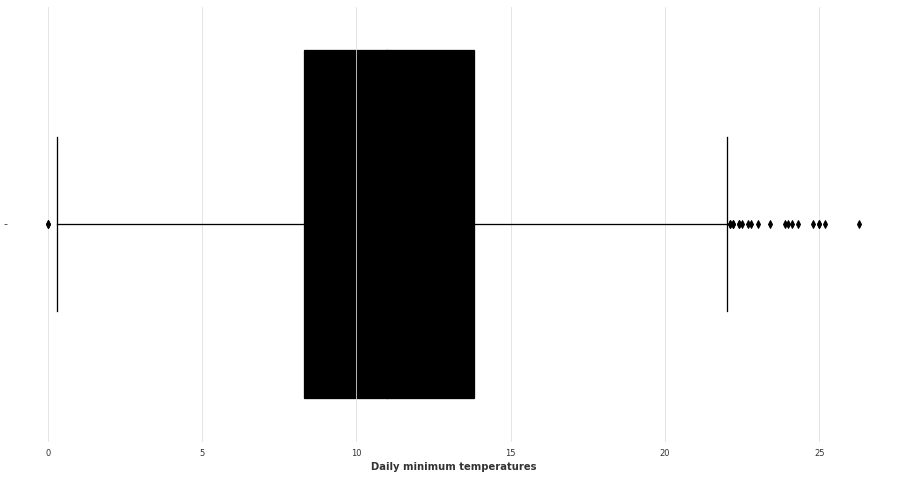

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x=train_temp["Daily minimum temperatures"], ax=ax)
plt.show()

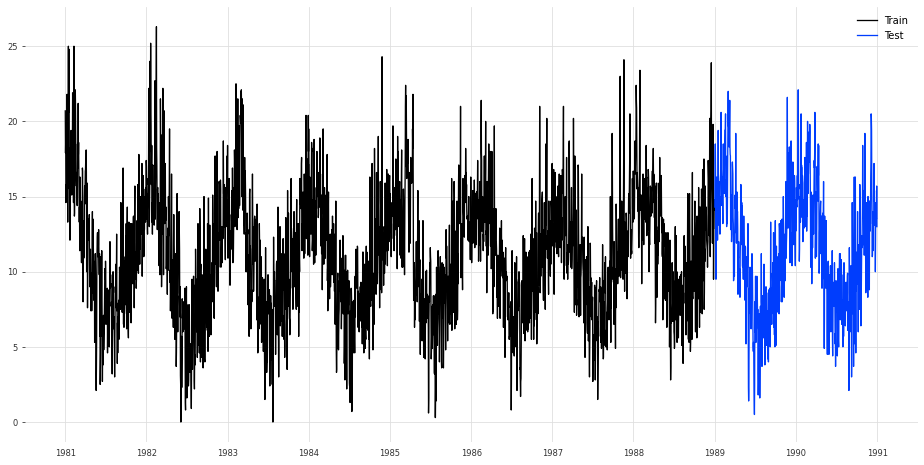

In [28]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(train_temp, label="Train")
ax.plot(test_temp, label="Test")
plt.legend(loc='upper right')
plt.show()

It is clear that the temperatures present a clear seasonality, as winters tend to be colder and summers tend to be hotter. In this particular case, as we are talking about Melbourne we must take care not to confound the seasons with the ones in the North Hemisphere of the Earth (Winter at the beggining of the year and Summer in the middle).

As the dataset has too many points (days) it has a lot of noise which can alter and reduce the efficiency of our forecasts. For that reason, we are going to resample the data to get the minimum temperature of each week and thus deal with the problems linked to the previously mentioned noise:

In [64]:
train_temp_weekly = train_temp.resample(rule="W").min()
test_temp_weekly = test_temp.resample(rule="W").min()

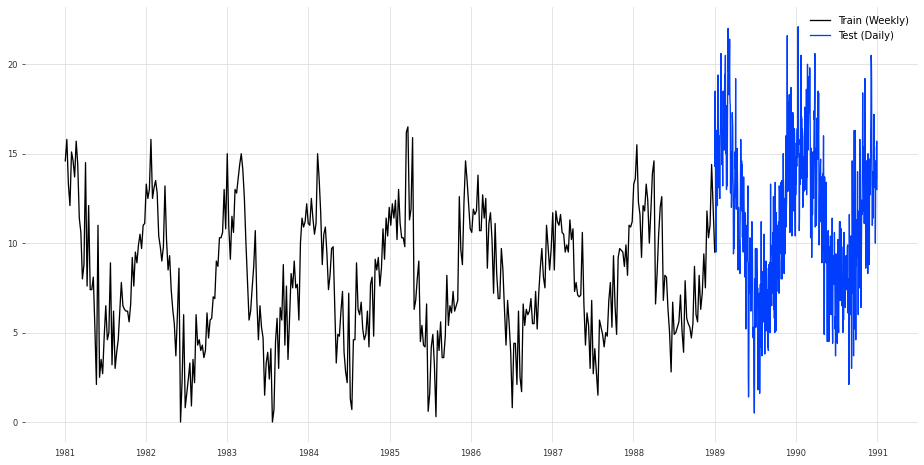

In [61]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(train_temp_weekly, label="Train (Weekly)")
ax.plot(test_temp, label="Test (Daily)")
plt.legend(loc='upper right')
plt.show()

Now if we take a look at the data we can perceive that the weekly data is more easily understandable, and communicates better the evolution fo the minimum temperartures, while the test data still in daily format shows quite a bit of noise in their observations.

Now, we will be using DARTS library functionalities to analyze the seasonality present in the dataset and to confirm its degree:

In [117]:
# We convert the dataset to a TimeSeries object
train_temp_series = TimeSeries.from_dataframe(train_temp, freq="D")
test_temp_series = TimeSeries.from_dataframe(test_temp, freq="D")

train_temp_weekly_series = TimeSeries.from_dataframe(train_temp_weekly, freq="W")
test_temp_weekly_series = TimeSeries.from_dataframe(test_temp_weekly, freq="W")

In [120]:
for i in range(2, 53):
    is_seasonal, m = check_seasonality(train_temp_weekly_series, i, max_lag=604)
    if is_seasonal:
        print(f"The dataset has a seasonality of degree {m}")

The dataset has a seasonality of degree 50
The dataset has a seasonality of degree 52


As we can see, the dataset has a seasonality of 50-52 weeks, which accounts to a year, meaning that the observations of a particular week are highly related with those of the same week the previous year. We can observe this visualy using the ACF plot:

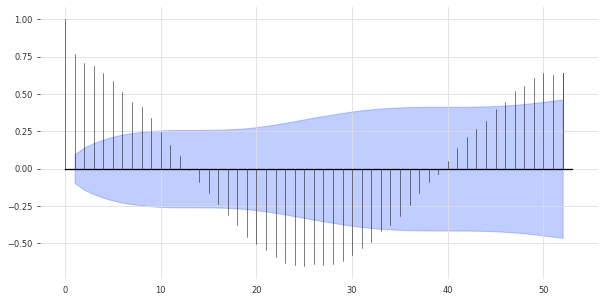

In [121]:
plot_acf(train_temp_weekly_series, m=52, max_lag=52)

## Forecasting 

First of all, we must take into account that `darts` is a compendium of different statistical models to perform forecasting, and as such facilitates the usage of different ones of these models in the same analysis. For this reason, we may use a function to evaluate our models and thus select which of the different possibilities is best for this case.

In [122]:
for model in (NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta
):
    try:
        eval_darts_model(model(), train_temp_series, test_temp_series, mae)
    except Exception:
        pass

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The error of the model Naive seasonal model, with K=1 is: 3.986145556708913
The error of the model Naive drift model is: 3.6453115440502306
The error of the model Prophet is: 2.3638865860376415
The error of the model Exponential smoothing is: nan


[2021-11-14 00:32:17,266] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 1460.
INFO:darts.utils.statistics:The ACF has no local maximum for m < max_lag = 1460.
[2021-11-14 00:32:17,267] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 0
[2021-11-14 00:32:17,267] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 0
INFO:darts.models.forecasting.theta:Theta model inferred seasonality of training series: 0


The error of the model ARIMA(12, 1, 0) is: 4.031665001816861


As we can see, the Prophet model retrieves the best results as its error is the lowest. Nevertheless, we may do some tweeking of the model in order to get even better results:

In [151]:
model = Prophet(
    growth="flat",
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode="additive"
)

In [152]:
eval_darts_model(model, train_temp_series, test_temp_series, mae)

The error of the model Prophet is: 1.9988308432392965


In [153]:
prediction = model.predict(len(test_temp_series))

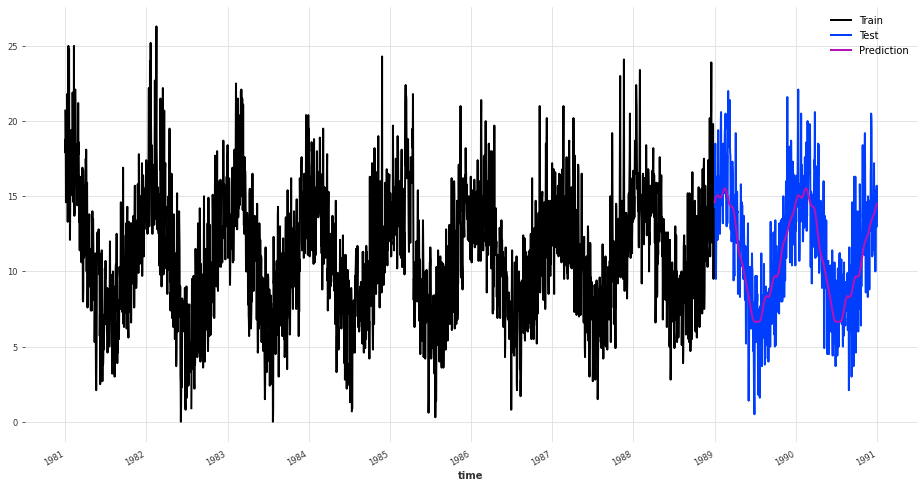

In [154]:
fig, ax = plt.subplots(figsize=(16, 8)) 
train_temp_series.plot(label="Train")
test_temp_series.plot(label="Test")
prediction.plot(label="Prediction")
plt.show()

By modifying the growth to a flat one, and selecting a yearly trend and an additive seasonality we have reached a 15% better scoring, which we should be proud of. Prophet is a model that can get good results and deals with several inconsistencies of our data by its own, but we must be careful because it is computationally expensive.